### This notebook is for demonstration purposes only 
### Inference only

Replaced 'head.fc' with new Linear layer.
Set 'head' parameters to require gradients.



Test Top-1 Accuracy: 99.7382
Confusion Matrix:
[[156   0   0]
 [  0 132   0]
 [  0   1  93]]


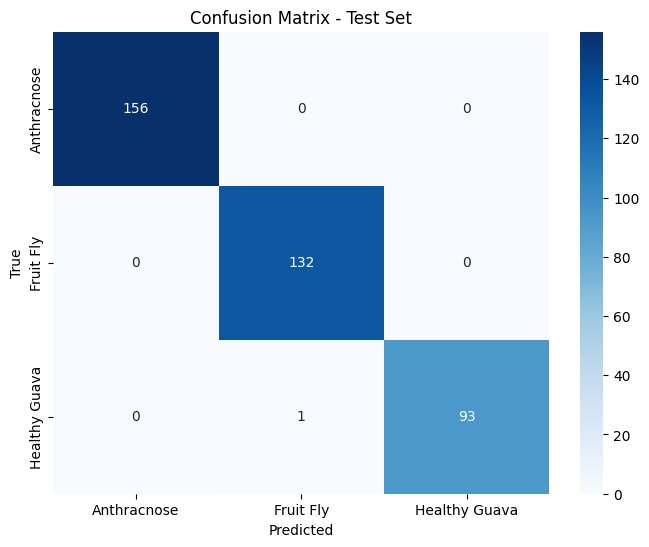

Classification Report:
               precision    recall  f1-score   support

  Anthracnose       1.00      1.00      1.00       156
    Fruit Fly       0.99      1.00      1.00       132
Healthy Guava       1.00      0.99      0.99        94

     accuracy                           1.00       382
    macro avg       1.00      1.00      1.00       382
 weighted avg       1.00      1.00      1.00       382



In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from models.model import GuavaClassifier
from src.utils import get_device, AverageMeter
from src.data_preprocessing import load_data

config = {
    'data': {
        'train_dir': '../data/GuavaDiseaseDataset/GuavaDiseaseDataset/train', # Need to fix for inference only test_dir should be provided
        'val_dir': '../data/GuavaDiseaseDataset/GuavaDiseaseDataset/val',  
        'test_dir': '../data/GuavaDiseaseDataset/GuavaDiseaseDataset/test',
        'batch_size': 4,
        'class_names': [   # Need to fix, very sensitive to the order of the folders etc.
            'Anthracnose',
            'Fruit Fly',
            'Healthy Guava'
        ]
    },
    'model': {
        'num_classes': 3
    },
    'training': {
        'save_path': '../models/best_M11217073.pth',
    }
}

_, _, test_loader = load_data(config)

model = GuavaClassifier(num_classes=config['model']['num_classes'])
device = get_device()
model = model.to(device)

model.load_state_dict(torch.load(config['training']['save_path'], map_location=device, weights_only=True))
model.eval()

criterion = torch.nn.CrossEntropyLoss()

correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating Test Set", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

test_top1_acc = correct_test / total_test * 100
print(f"\nTest Top-1 Accuracy: {test_top1_acc:.4f}")

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

cm = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=config['data']['class_names'],
            yticklabels=config['data']['class_names'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

class_report = classification_report(all_labels, all_preds, target_names=config['data']['class_names'])
print(f"Classification Report:\n{class_report}")

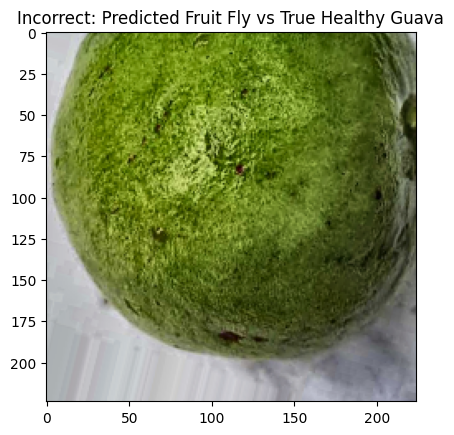

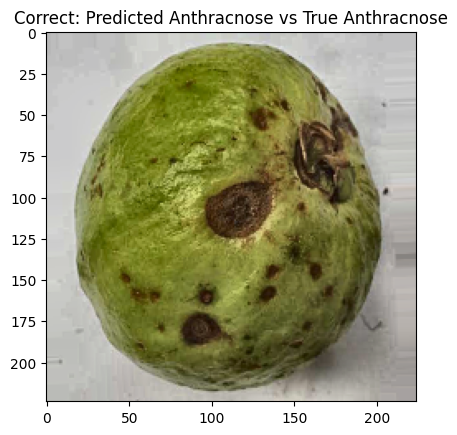

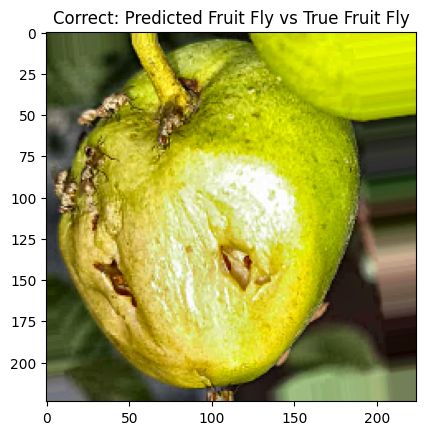

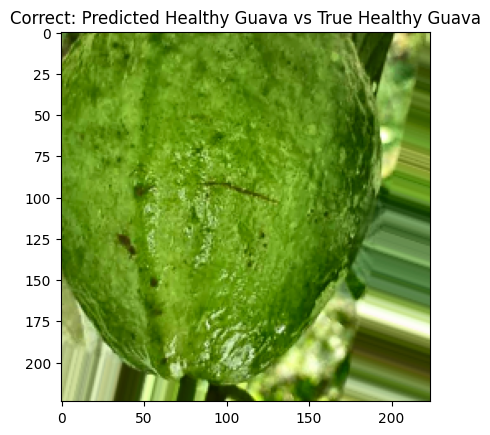

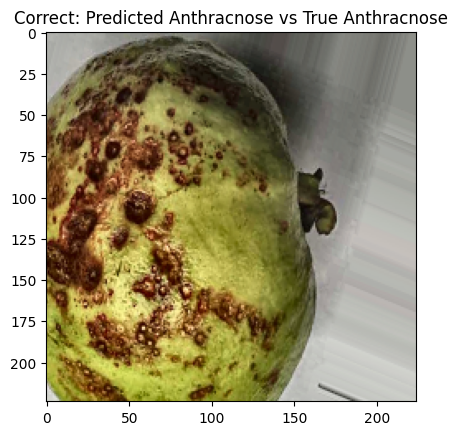

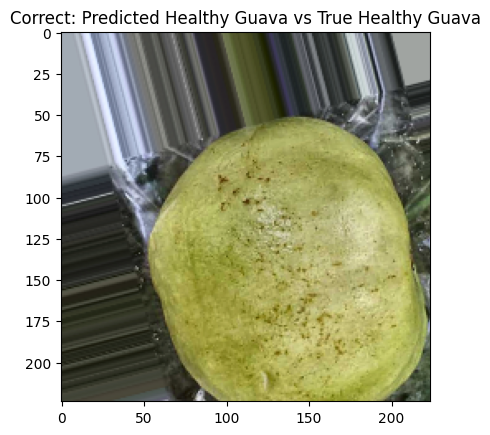

In [34]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Function to display images
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))  # Move tensor to CPU and convert to NumPy image
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])   # ImageNet std
    inp = std * inp + mean  # Normalize back
    inp = np.clip(inp, 0, 1)  # Clip the values to [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get the list of correct and incorrect indices
incorrect_indices = np.where(all_preds != all_labels)[0]
correct_indices = np.where(all_preds == all_labels)[0]

# Display all incorrect predictions
for idx in incorrect_indices:
    inputs, labels = test_loader.dataset[idx]
    inputs = inputs.unsqueeze(0).to(device)
    labels = torch.tensor([labels]).to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Show image and the misclassified label
    imshow(inputs.squeeze(0).cpu())
    plt.title(f"Incorrect: Predicted {config['data']['class_names'][preds]} vs True {config['data']['class_names'][labels]}")
    plt.show()

# Display some correct predictions (e.g., 5 random ones)
sample_correct = random.sample(list(correct_indices), 5) if correct_indices.size > 0 else []
for idx in sample_correct:
    inputs, labels = test_loader.dataset[idx]
    inputs = inputs.unsqueeze(0).to(device)
    labels = torch.tensor([labels]).to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Show image and the correct label
    imshow(inputs.squeeze(0).cpu())
    plt.title(f"Correct: Predicted {config['data']['class_names'][preds]} vs True {config['data']['class_names'][labels]}")
    plt.show()

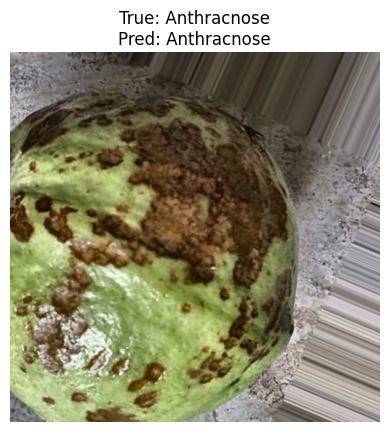

True Label: Anthracnose
Predicted Label: Anthracnose


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_path = "sample/sample_anth.png"
image = Image.open(image_path).convert("RGB")

input_tensor = transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_class = torch.max(output, 1) 

class_names = config['data']['class_names']
plt.imshow(np.array(image))
predicted_label = class_names[predicted_class.item()]
true_label = "Anthracnose"
plt.title(f"True: {true_label}\nPred: {predicted_label}")
plt.axis('off')
plt.show()

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")